# **Bootstrapping of Dictionaries** 

## **Document Level**

In [4]:
# packages
!pip install sentence-transformers==2.2.2
!pip install huggingface_hub #==0.25.1

!pip install wordcloud
!pip install adjustText

  Using cached huggingface_hub-0.30.2-py3-none-any.whl.metadata (13 kB)
Using cached huggingface_hub-0.30.2-py3-none-any.whl (481 kB)
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.25.1
    Uninstalling huggingface-hub-0.25.1:
      Successfully uninstalled huggingface-hub-0.25.1


In [5]:
import pandas as pd
import random
import numpy as np
from tqdm import tqdm

from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
import os
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import json
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patches as patches

from sklearn.feature_extraction.text import TfidfVectorizer
import math
from adjustText import adjust_text
from scipy.stats import pearsonr
from numpy import linalg as LA
from scipy.stats import zscore
import zipfile
from sklearn.model_selection import train_test_split


## Models and Dictionaries

In [5]:
# import models

# AFTER POOL

finetuned_model = SentenceTransformer('../00_embedding_models/after_pool_finetuned_sentence_model_wordlim_10_window_5')
self_build_model = SentenceTransformer('../00_embedding_models/after_pool_self_build_sentence_model_wordlim_10_window_5')

# import dictionaries
evidence = pd.read_csv("../dictionaries_emi/evidence_lexicon.csv")
intuition = pd.read_csv("../dictionaries_emi/intuition_lexicon.csv")


In [6]:
# Get embeddings for dictionary words

finetuned_evidence_embeddings = finetuned_model.encode(evidence['evidence_keywords'])
finetuned_intuition_embeddings = finetuned_model.encode(intuition['intuition_keywords'])

self_evidence_embeddings = self_build_model.encode(evidence['evidence_keywords'])
self_intuition_embeddings = self_build_model.encode(intuition['intuition_keywords'])


In [7]:

# their norm
evidence_norms_ft = np.linalg.norm(finetuned_evidence_embeddings, axis=1)
intuition_norms_ft = np.linalg.norm(finetuned_intuition_embeddings, axis=1)

evidence_norms_sb = np.linalg.norm(self_evidence_embeddings, axis=1)
intuition_norms_sb = np.linalg.norm(self_intuition_embeddings, axis=1)


# z-scores
evidence_zscores_ft = zscore(evidence_norms_ft)
intuition_zscores_ft = zscore(intuition_norms_ft)

evidence_zscores_sb = zscore(evidence_norms_sb)
intuition_zscores_sb = zscore(intuition_norms_sb)


# Make df
df_evidence = pd.DataFrame({
    "word": evidence['evidence_keywords'],
    "embedding_ft": list(finetuned_evidence_embeddings), 
    "embedding_sb": list(self_evidence_embeddings), 
    "norm_ft": evidence_norms_ft,
    "norm_sb": evidence_norms_sb,
    "z-score_ft": evidence_zscores_ft,
    "z-score_sb": evidence_zscores_sb
})


df_intuition = pd.DataFrame({
    "word": intuition['intuition_keywords'],
    "embedding_ft": list(finetuned_intuition_embeddings), 
    "embedding_sb": list(self_intuition_embeddings), 
    "norm_ft": intuition_norms_ft,
    "norm_sb": intuition_norms_sb,
    "z-score_ft": intuition_zscores_ft,
    "z-score_sb": intuition_zscores_sb
})


In [8]:
df_evidence
#df_intuition

,word,embedding_ft,embedding_sb,norm_ft,norm_sb,z-score_ft,z-score_sb
0,accurate,"[-0.07633275, -0.11705223, -0.094368055, 0.006...","[-0.020695282, 0.07546731, -0.10320894, -0.033...",1.0,1.0,-1.649916,0.000000
1,analyse,"[-0.011831486, -0.024427377, -0.0051206592, 0....","[-0.030805515, -0.040031154, -0.08503759, -0.0...",1.0,1.0,0.000000,0.000000
2,analysis,"[0.0039203446, -0.014852947, 0.023248818, 0.02...","[-0.03762376, 0.032084078, -0.03233184, -0.100...",1.0,1.0,-1.649916,0.000000
3,correct,"[-0.0966623, -0.08371393, -0.05452827, 0.00539...","[0.039523017, 0.026090413, -0.046577457, 0.000...",1.0,1.0,0.000000,-2.110579
4,correction,"[0.036097363, -0.0025274577, 0.079878196, -0.0...","[0.03978918, -0.019495297, 0.010020363, -0.111...",1.0,1.0,0.000000,-2.110579
5,data,"[-0.04315679, -0.082168505, -0.10087393, 0.052...","[-0.078547694, -0.03939558, -0.08206244, -0.00...",1.0,1.0,-1.649916,0.000000
6,dossier,"[-0.040630437, 0.07168719, -0.040785927, -0.01...","[0.0012046405, 0.06859794, 0.03353569, 0.09652...",1.0,1.0,0.000000,0.000000
7,education,"[0.040275365, -0.042782947, 0.061504137, 0.040...","[0.0019918603, 0.052030995, -0.018174289, -0.0...",1.0,1.0,0.000000,0.000000
8,evidence,"[0.015212556, -0.01919913, -0.058649577, 0.016...","[-0.12124397, 0.11885475, -0.018625965, -0.019...",1.0,1.0,0.000000,-2.110579
9,evident,"[-0.05033586, -0.04429693, 0.06724591, 0.07282...","[0.039442338, 0.102390856, 0.027916148, -0.007...",1.0,1.0,0.000000,-2.110579


In [9]:
# this needs to be randomized

# mean of word embeddings, then normalize --> concept embedding

evidence_dim_ft = df_evidence['embedding_ft'].mean(axis = 0) / LA.norm(df_evidence['embedding_ft'].mean(axis = 0))
intuition_dim_ft = df_intuition['embedding_ft'].mean(axis = 0) / LA.norm(df_intuition['embedding_ft'].mean(axis = 0))

evidence_dim_sb = df_evidence['embedding_sb'].mean(axis = 0) / LA.norm(df_evidence['embedding_sb'].mean(axis = 0))
intuition_dim_sb = df_intuition['embedding_sb'].mean(axis = 0) / LA.norm(df_intuition['embedding_sb'].mean(axis = 0))

## Bootstrap Dictionaries

In [10]:
# generate random lengths

np.random.seed(23)
random_dict_length_e = np.random.randint(low = 30, high = (len(df_evidence)), size = 1000)
random_dict_length_i = np.random.randint(low = 30, high = (len(df_intuition)), size = 1000)

In [11]:
random_dict_length_e

array([36, 38, 39, 38, 43, 42, 37, 36, 43, 42, 47, 32, 41, 35, 30, 42, 46,
       39, 45, 31, 37, 45, 34, 31, 31, 41, 45, 37, 32, 40, 42, 33, 30, 43,
       36, 44, 30, 36, 30, 32, 30, 44, 44, 46, 36, 32, 48, 41, 40, 37, 40,
       35, 36, 34, 41, 38, 30, 34, 41, 31, 39, 35, 39, 37, 47, 30, 33, 40,
       40, 36, 34, 30, 48, 31, 38, 32, 34, 30, 41, 34, 30, 47, 44, 39, 35,
       36, 35, 37, 34, 46, 36, 39, 46, 45, 41, 47, 36, 32, 30, 45, 30, 46,
       45, 32, 32, 40, 32, 38, 31, 44, 46, 36, 36, 32, 43, 36, 40, 33, 40,
       33, 47, 39, 31, 46, 47, 47, 36, 41, 34, 41, 46, 33, 33, 37, 40, 48,
       46, 37, 31, 38, 47, 36, 34, 40, 47, 33, 48, 40, 47, 30, 39, 36, 39,
       30, 43, 34, 32, 47, 31, 39, 33, 43, 48, 46, 32, 33, 33, 42, 35, 47,
       30, 34, 34, 38, 30, 43, 33, 40, 33, 39, 43, 47, 33, 36, 37, 37, 39,
       45, 39, 46, 40, 31, 47, 46, 39, 46, 46, 46, 45, 38, 39, 33, 35, 46,
       45, 37, 45, 40, 47, 37, 43, 35, 38, 33, 34, 43, 38, 46, 38, 36, 37,
       33, 45, 34, 33, 43

In [12]:
# sample my 1000 evidence and intuition dictionaries of the random lengths

rand_dict_e = {}
for idx, rand_len in enumerate(random_dict_length_e):

    rand_dict_e[idx] = df_evidence.sample(rand_len, random_state = 23).reset_index(drop = True) 



rand_dict_i = {}
for idx, rand_len in enumerate(random_dict_length_i):

    rand_dict_i[idx] = df_intuition.sample(rand_len, random_state = 23).reset_index(drop = True) 

    

In [13]:
# calculate random e and i dimensions (average random dict-words embeddings)

rand_e_dim = {}
for idx, rand_df in rand_dict_e.items():

    rand_e_dim[idx] = {}
    
    rand_e_dim[idx]['evidence_dim_ft'] = rand_df['embedding_ft'].mean(axis = 0) / LA.norm(rand_df['embedding_ft'].mean(axis = 0))
    rand_e_dim[idx]['evidence_dim_sb'] = rand_df['embedding_sb'].mean(axis = 0) / LA.norm(rand_df['embedding_sb'].mean(axis = 0))

   

rand_i_dim = {}
for idx, rand_df in rand_dict_i.items():

    rand_i_dim[idx] = {}
    
    rand_i_dim[idx]['intuition_dim_ft'] = rand_df['embedding_ft'].mean(axis = 0) / LA.norm(rand_df['embedding_ft'].mean(axis = 0))
    rand_i_dim[idx]['intuition_dim_sb'] = rand_df['embedding_sb'].mean(axis = 0) / LA.norm(rand_df['embedding_sb'].mean(axis = 0))


    
    

## Import Documents

* Import all subreddits
* From each subreddit, get unique texts (unique com, rep, sub)
* Embedd only unique texts

In [26]:
test = pd.read_csv(f"output_clipped/politics_5_emb.csv")
test.columns

# averaging word embeddings --> word embeddings are technically normalizes (due to post-pool-model)
# For consistency: need to rerun embeddings of subreddits_reduced to save the embedding vectors (using non-normalizes word embeddings)

Index(['msg_id_parent', 'msg_id_child', 'submission_id', 'subreddit',
       'exact_time_child', 'author_child', 'author_parent',
       'author_submission', 'parent_tokens', 'parent_len', 'child_tokens',
       'child_len', 'submission_tokens', 'submission_len',
       'finetuned_parent_E_emb', 'finetuned_parent_I_emb',
       'finetuned_child_E_emb', 'finetuned_child_I_emb',
       'finetuned_submission_E_emb', 'finetuned_submission_I_emb',
       'self_parent_E_emb', 'self_parent_I_emb', 'self_child_E_emb',
       'self_child_I_emb', 'self_submission_E_emb', 'self_submission_I_emb',
       'finetuned_parent_E', 'finetuned_parent_I', 'finetuned_child_E',
       'finetuned_child_I', 'finetuned_submission_E', 'finetuned_submission_I',
       'self_parent_E', 'self_parent_I', 'self_child_E', 'self_child_I',
       'self_submission_E', 'self_submission_I'],
      dtype='object')

In [18]:
subreddits = ["Ask_Politics", "Askpolitics", "PoliticalDebate", "PoliticalDiscussion", "NeutralPolitics", "politics"]

unique_texts_all = pd.DataFrame()

for subr in subreddits:

    if subr == "politics":
        
        df = pd.DataFrame()
        for i in range(8):
            df_temp = pd.read_csv(f"output_clipped/politics_{i}_emb.csv")[['msg_id_parent', 'msg_id_child', 'submission_id', 
                                                            'subreddit', 'finetuned_parent_E_emb', 'finetuned_parent_I_emb',
                                                            'finetuned_child_E_emb', 'finetuned_child_I_emb',
                                                            'finetuned_submission_E_emb', 'finetuned_submission_I_emb',
                                                            'self_parent_E_emb', 'self_parent_I_emb', 'self_child_E_emb',
                                                            'self_child_I_emb', 'self_submission_E_emb', 'self_submission_I_emb']]
            df = pd.concat([df, df_temp]).reset_index(drop = True)
            print("Done with politics")

    else:
        df = pd.read_csv(f"output_clipped/{subr}_emb.csv")[['msg_id_parent', 'msg_id_child', 'submission_id', 
                                                        'subreddit', 'finetuned_parent_E_emb', 'finetuned_parent_I_emb',
                                                        'finetuned_child_E_emb', 'finetuned_child_I_emb',
                                                        'finetuned_submission_E_emb', 'finetuned_submission_I_emb',
                                                        'self_parent_E_emb', 'self_parent_I_emb', 'self_child_E_emb',
                                                        'self_child_I_emb', 'self_submission_E_emb', 'self_submission_I_emb']]
    
    
    comments_df = df[['subreddit', 'msg_id_parent', 'finetuned_parent_E_emb', 'finetuned_parent_I_emb', 
                      'self_parent_E_emb','self_parent_I_emb']].dropna().drop_duplicates().copy()
    comments_df.columns = ['subreddit', 'id', 'finetuned_E_emb', 'finetuned_I_emb', 'self_E_emb', 'self_I_emb']
    comments_df['type'] = 'parent'
    
    
    
    replies_df = df[['subreddit', 'msg_id_child', 'finetuned_child_E_emb', 'finetuned_child_I_emb', 
                      'self_child_E_emb','self_child_I_emb']].dropna().drop_duplicates().copy()
    replies_df.columns = ['subreddit', 'id', 'finetuned_E_emb', 'finetuned_I_emb', 'self_E_emb', 'self_I_emb']
    replies_df['type'] = 'child'
    
    subs_df = df[['subreddit', 'submission_id', 'finetuned_submission_E_emb', 'finetuned_submission_I_emb', 
                      'self_submission_E_emb','self_submission_I_emb']].dropna().drop_duplicates().copy()
    subs_df.columns = ['subreddit', 'id', 'finetuned_E_emb', 'finetuned_I_emb', 'self_E_emb', 'self_I_emb']
    subs_df['type'] = 'submission'
    
    # Concatenate into one unified dataframe
    unique_text_df = pd.concat([comments_df, replies_df, subs_df], ignore_index=True)
    unique_texts_all = pd.concat([unique_texts_all, unique_text_df]).reset_index(drop = True)
    
    # Optional: remove exact duplicate texts (if you only want unique *text bodies*)
    #unique_text_df = unique_text_df.drop_duplicates(subset='text')

unique_texts_all

Done with politics
Done with politics
Done with politics
Done with politics
Done with politics
Done with politics
Done with politics
Done with politics


,subreddit,id,finetuned_E_emb,finetuned_I_emb,self_E_emb,self_I_emb,type
0,Ask_Politics,c7ecp8d,[-4.76003326e-02 -1.46762103e-01 -3.61844189e-...,[-4.80658151e-02 -1.51403949e-01 -3.41269039e-...,[-8.84473547e-02 -7.27445483e-02 -2.76126433e-...,[-7.99003243e-02 -5.50682396e-02 -1.50816888e-...,parent
1,Ask_Politics,c7ecp8d,[-4.76003215e-02 -1.46762103e-01 -3.61844189e-...,[-4.80658151e-02 -1.51403949e-01 -3.41269039e-...,[-8.84473547e-02 -7.27445483e-02 -2.76126433e-...,[-7.99003243e-02 -5.50682396e-02 -1.50816888e-...,parent
2,Ask_Politics,c7efx8q,[-1.02094412e-02 -9.24783573e-02 -4.73322421e-...,[-1.40088554e-02 -9.39689502e-02 -5.19807860e-...,[-0.07347714 -0.08556745 -0.04668841 -0.089152...,[-0.07883871 -0.08937386 -0.0251009 -0.086172...,parent
3,Ask_Politics,c7edr13,[-0.1514677 -0.08389024 -0.05855702 0.031323...,[-0.1514677 -0.08389024 -0.05855702 0.031323...,[ 0.02760824 0.01997875 -0.05295471 -0.011017...,[ 0.02760824 0.01997875 -0.05295471 -0.011017...,parent
4,Ask_Politics,c7ee45j,[-9.66596827e-02 -1.11204185e-01 4.23600227e-...,[-0.07512397 -0.1114663 0.04122218 0.063893...,[ 0.03154784 0.01630055 -0.01708008 -0.037941...,[ 0.0071187 0.03205186 -0.00136118 -0.006023...,parent
...,...,...,...,...,...,...,...
6332034,politics,18mfx16,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[ 0.01122897 -0.07402615 -0.02143793 -0.054434...,[-0.08886193 -0.10358876 0.09133755 -0.082816...,[-6.31521717e-02 -6.48423731e-02 1.24256641e-...,submission
6332035,politics,18mfyba,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[ 0.01122897 -0.07402615 -0.02143793 -0.054434...,[-0.08886193 -0.10358876 0.09133755 -0.082816...,[-6.31521717e-02 -6.48423731e-02 1.24256641e-...,submission
6332036,politics,18p9iet,[-1.97313260e-02 -9.52264741e-02 -3.00611891e-...,[-4.64484952e-02 -5.70505597e-02 3.74149974e-...,[-1.01922909e-04 -7.39901364e-02 4.47226837e-...,[-0.04607026 -0.04783577 0.03144358 0.015881...,submission
6332037,politics,18qmiau,[-0.03399328 -0.12132413 -0.01787407 -0.043583...,[-0.06122696 -0.12083462 -0.02588171 -0.034055...,[-3.87358963e-02 -4.31307107e-02 -3.20733897e-...,[-0.04963562 -0.01706254 -0.01176096 -0.086840...,submission


In [19]:
unique_texts_all_formatted = unique_texts_all.copy(deep = True)
unique_texts_all_formatted

,subreddit,id,finetuned_E_emb,finetuned_I_emb,self_E_emb,self_I_emb,type
0,Ask_Politics,c7ecp8d,[-4.76003326e-02 -1.46762103e-01 -3.61844189e-...,[-4.80658151e-02 -1.51403949e-01 -3.41269039e-...,[-8.84473547e-02 -7.27445483e-02 -2.76126433e-...,[-7.99003243e-02 -5.50682396e-02 -1.50816888e-...,parent
1,Ask_Politics,c7ecp8d,[-4.76003215e-02 -1.46762103e-01 -3.61844189e-...,[-4.80658151e-02 -1.51403949e-01 -3.41269039e-...,[-8.84473547e-02 -7.27445483e-02 -2.76126433e-...,[-7.99003243e-02 -5.50682396e-02 -1.50816888e-...,parent
2,Ask_Politics,c7efx8q,[-1.02094412e-02 -9.24783573e-02 -4.73322421e-...,[-1.40088554e-02 -9.39689502e-02 -5.19807860e-...,[-0.07347714 -0.08556745 -0.04668841 -0.089152...,[-0.07883871 -0.08937386 -0.0251009 -0.086172...,parent
3,Ask_Politics,c7edr13,[-0.1514677 -0.08389024 -0.05855702 0.031323...,[-0.1514677 -0.08389024 -0.05855702 0.031323...,[ 0.02760824 0.01997875 -0.05295471 -0.011017...,[ 0.02760824 0.01997875 -0.05295471 -0.011017...,parent
4,Ask_Politics,c7ee45j,[-9.66596827e-02 -1.11204185e-01 4.23600227e-...,[-0.07512397 -0.1114663 0.04122218 0.063893...,[ 0.03154784 0.01630055 -0.01708008 -0.037941...,[ 0.0071187 0.03205186 -0.00136118 -0.006023...,parent
...,...,...,...,...,...,...,...
6332034,politics,18mfx16,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[ 0.01122897 -0.07402615 -0.02143793 -0.054434...,[-0.08886193 -0.10358876 0.09133755 -0.082816...,[-6.31521717e-02 -6.48423731e-02 1.24256641e-...,submission
6332035,politics,18mfyba,[ 1.76615994e-02 -7.04686046e-02 -2.22658794e-...,[ 0.01122897 -0.07402615 -0.02143793 -0.054434...,[-0.08886193 -0.10358876 0.09133755 -0.082816...,[-6.31521717e-02 -6.48423731e-02 1.24256641e-...,submission
6332036,politics,18p9iet,[-1.97313260e-02 -9.52264741e-02 -3.00611891e-...,[-4.64484952e-02 -5.70505597e-02 3.74149974e-...,[-1.01922909e-04 -7.39901364e-02 4.47226837e-...,[-0.04607026 -0.04783577 0.03144358 0.015881...,submission
6332037,politics,18qmiau,[-0.03399328 -0.12132413 -0.01787407 -0.043583...,[-0.06122696 -0.12083462 -0.02588171 -0.034055...,[-3.87358963e-02 -4.31307107e-02 -3.20733897e-...,[-0.04963562 -0.01706254 -0.01176096 -0.086840...,submission


In [20]:
# fix formatting of embedding vectors 


def fix_string_vector(s):
    if pd.isna(s):
        return np.array([])
    
    s = s.strip().replace('[', '').replace(']', '')
    
    # Replace all kinds of separators with single space
    s = re.sub(r'[,\s]+', ' ', s).strip()
    
    try:
        return np.fromstring(s, sep=' ')
    except:
        return np.array([])

# Apply to all embedding columns
embedding_cols = [col for col in unique_texts_all_formatted.columns if '_emb' in col]

for col in embedding_cols:
    unique_texts_all_formatted[col] = unique_texts_all_formatted[col].apply(fix_string_vector)



6332039 rows instead of 7035721 because some text don't habe pos E or pos I words --> clipping removed so nothing to encode: drop

In [36]:
# make a stratified dample

df_sample, df_test = train_test_split(unique_texts_all_formatted, test_size=0.95, stratify=unique_texts_all_formatted[["subreddit", "type"]])

In [38]:
print(len(df_sample))
df_sample['subreddit'].value_counts()

316601


subreddit
politics               254407
PoliticalDiscussion     51749
Ask_Politics             5422
NeutralPolitics          3558
PoliticalDebate           738
Askpolitics               727
Name: count, dtype: int64

In [39]:
doc_similarities_dict = {}

for doc_id in tqdm(df_sample["id"], desc="Processing words"):
    
    # take embeddings
    doc_E_emb_ft = df_sample.loc[df_sample["id"] == doc_id, 'finetuned_E_emb'].values[0]
    doc_I_emb_ft = df_sample.loc[df_sample["id"] == doc_id, 'finetuned_I_emb'].values[0]
    
    doc_E_emb_sb = df_sample.loc[df_sample["id"] == doc_id, 'self_E_emb'].values[0]
    doc_I_emb_sb = df_sample.loc[df_sample["id"] == doc_id, 'self_I_emb'].values[0]

    # make dict with both models: lists of cos-sim
    doc_similarities_dict[doc_id] = {
        'e_sim_ft': [],
        'e_sim_sb': [],
        'i_sim_ft': [],
        'i_sim_sb': []
    }
    
    # for each random evidence dimension
    for idx, e_dim in rand_e_dim.items():
        sim_ft = cosine_similarity(doc_E_emb_ft.reshape(1, -1), e_dim['evidence_dim_ft'].reshape(1, -1))[0][0]
        sim_sb = cosine_similarity(doc_E_emb_sb.reshape(1, -1), e_dim['evidence_dim_sb'].reshape(1, -1))[0][0]

        doc_similarities_dict[doc_id]['e_sim_ft'].append(sim_ft)
        doc_similarities_dict[doc_id]['e_sim_sb'].append(sim_sb)


    # for each random intuition dimension
    for idx, i_dim in rand_i_dim.items():
        sim_ft = cosine_similarity(doc_I_emb_ft.reshape(1, -1), i_dim['intuition_dim_ft'].reshape(1, -1))[0][0]
        sim_sb = cosine_similarity(doc_I_emb_sb.reshape(1, -1), i_dim['intuition_dim_sb'].reshape(1, -1))[0][0]

        doc_similarities_dict[doc_id]['i_sim_ft'].append(sim_ft)
        doc_similarities_dict[doc_id]['i_sim_sb'].append(sim_sb)
    
   
    
    

Processing words: 100%|██████████| 316601/316601 [67:55:25<00:00,  1.29it/s]    


In [42]:
doc_similarities_dict['fbbkgjz']

{'e_sim_ft': [0.30685236539833266,
  0.29707091979666866,
  0.30425480436413654,
  0.29707091979666866,
  0.2963741788009371,
  0.30245194719124263,
  0.30180564636959256,
  0.30685236539833266,
  0.2963741788009371,
  0.30245194719124263,
  0.3046594107634448,
  0.33999876993478967,
  0.29937006267192323,
  0.3128239001711465,
  0.31609504884013184,
  0.30245194719124263,
  0.30838835141493537,
  0.30425480436413654,
  0.3070576670809792,
  0.33124935045057713,
  0.30180564636959256,
  0.3070576670809792,
  0.32249873683831604,
  0.33124935045057713,
  0.33124935045057713,
  0.29937006267192323,
  0.3070576670809792,
  0.30180564636959256,
  0.33999876993478967,
  0.30533210732465815,
  0.30245194719124263,
  0.3303408514689185,
  0.31609504884013184,
  0.2963741788009371,
  0.30685236539833266,
  0.29541863683554187,
  0.31609504884013184,
  0.30685236539833266,
  0.31609504884013184,
  0.33999876993478967,
  0.31609504884013184,
  0.29541863683554187,
  0.29541863683554187,
  0.3083

In [43]:

def make_json_serializable(obj):
    if isinstance(obj, dict):
        return {k: make_json_serializable(v) for k, v in obj.items()}
    elif isinstance(obj, list):
        return [make_json_serializable(i) for i in obj]
    elif isinstance(obj, np.ndarray):
        return obj.tolist()
    elif isinstance(obj, (np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.int32, np.int64)):
        return int(obj)
    else:
        return obj

# Convert data type
json_ready_doc_similarities_dict = make_json_serializable(doc_similarities_dict)


with open('output_bootstrapping/bootstrapped_doc_similarities.json', 'w') as f:
    json.dump(json_ready_doc_similarities_dict, f, indent=2)


In [1]:
subreddits = ['Ask_Politics' , 'Askpolitics', 'PoliticalDiscussion', 'PoliticalDebate', 'NeutralPolitics', 'politics']


# **Reimport**

In [6]:

with open('output_bootstrapping/bootstrapped_doc_similarities.json', 'r') as f:
    doc_sim_dict = json.load(f)


doc_sim_dict['fbbkgjz']

{'e_sim_ft': [0.30685236539833266,
  0.29707091979666866,
  0.30425480436413654,
  0.29707091979666866,
  0.2963741788009371,
  0.30245194719124263,
  0.30180564636959256,
  0.30685236539833266,
  0.2963741788009371,
  0.30245194719124263,
  0.3046594107634448,
  0.33999876993478967,
  0.29937006267192323,
  0.3128239001711465,
  0.31609504884013184,
  0.30245194719124263,
  0.30838835141493537,
  0.30425480436413654,
  0.3070576670809792,
  0.33124935045057713,
  0.30180564636959256,
  0.3070576670809792,
  0.32249873683831604,
  0.33124935045057713,
  0.33124935045057713,
  0.29937006267192323,
  0.3070576670809792,
  0.30180564636959256,
  0.33999876993478967,
  0.30533210732465815,
  0.30245194719124263,
  0.3303408514689185,
  0.31609504884013184,
  0.2963741788009371,
  0.30685236539833266,
  0.29541863683554187,
  0.31609504884013184,
  0.30685236539833266,
  0.31609504884013184,
  0.33999876993478967,
  0.31609504884013184,
  0.29541863683554187,
  0.29541863683554187,
  0.3083

In [7]:
result = pd.DataFrame(list(doc_sim_dict.keys()), columns = ["text_ids"])

result["Var_E_ft"] = None
result["Var_I_ft"] = None
result["Var_E_sb"] = None
result["Var_I_sb"] = None

result["Mean_E_ft"] = None
result["Mean_I_ft"] = None
result["Mean_E_sb"] = None
result["Mean_I_sb"] = None
result

,text_ids,Var_E_ft,Var_I_ft,Var_E_sb,Var_I_sb,Mean_E_ft,Mean_I_ft,Mean_E_sb,Mean_I_sb
0,danzbkr,None,None,None,None,None,None,None,None
1,fbbkgjz,None,None,None,None,None,None,None,None
2,c703i21,None,None,None,None,None,None,None,None
3,cxqslcl,None,None,None,None,None,None,None,None
4,gbjgkft,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...
316566,eizd85n,None,None,None,None,None,None,None,None
316567,jeccop7,None,None,None,None,None,None,None,None
316568,gjygnpz,None,None,None,None,None,None,None,None
316569,fmsrtn6,None,None,None,None,None,None,None,None


In [8]:
for idx, row in result.iterrows():
    id = row["text_ids"]
    sims = doc_sim_dict[id]

    # Finetuned model similarities (evidence + intuition)
    result.at[idx, "Var_E_ft"] = np.var(sims["e_sim_ft"])
    result.at[idx, "Mean_E_ft"] = np.mean(sims["e_sim_ft"])

    result.at[idx, "Var_I_ft"] = np.var(sims["i_sim_ft"])
    result.at[idx, "Mean_I_ft"] = np.mean(sims["i_sim_ft"])

    # Self model similarities (evidence + intuition)
    result.at[idx, "Var_E_sb"] = np.var(sims["e_sim_sb"])
    result.at[idx, "Mean_E_sb"] = np.mean(sims["e_sim_sb"])

    result.at[idx, "Var_I_sb"] = np.var(sims["i_sim_sb"])
    result.at[idx, "Mean_I_sb"] = np.mean(sims["i_sim_sb"])

In [15]:
result.to_csv("output_bootstrapping/doc_var_mean_table.csv", index = False)

# **BVR and CI**

In [9]:
def compute_bvr(df, var_col, mean_col):
    MV = np.round(df[var_col].mean(), 6)
    TV = np.round(np.var(df[mean_col], ddof=1), 6)  # Sample variance
    BVR = np.round(MV / TV, 6) if TV != 0 else np.nan
    return MV, TV, BVR


In [10]:
metrics = {
    "E_ft": ("Var_E_ft", "Mean_E_ft"),
    "I_ft": ("Var_I_ft", "Mean_I_ft"),
    "E_sb": ("Var_E_sb", "Mean_E_sb"),
    "I_sb": ("Var_I_sb", "Mean_I_sb")
}

results_summary = {}

for label, (var_col, mean_col) in metrics.items():
    MV, TV, BVR = compute_bvr(result, var_col, mean_col)
    results_summary[label] = {
        "MV": MV,
        "TV": TV,
        "BVR": BVR
    }


In [11]:
def bootstrap_bvr(df, var_col, mean_col, n_boot=1000, seed=42):
    rng = np.random.default_rng(seed)
    bvr_samples = []
    
    for _ in range(n_boot):
        sample = df.sample(frac=1.0, replace=True, random_state=rng)
        MV = sample[var_col].mean()
        TV = np.var(sample[mean_col], ddof=1)
        bvr = MV / TV if TV != 0 else np.nan
        bvr_samples.append(bvr)
    
    bvr_array = np.array(bvr_samples)
    ci_lower = np.percentile(bvr_array, 2.5)
    ci_upper = np.percentile(bvr_array, 97.5)
    
    return bvr_array.mean(), (ci_lower, ci_upper)


In [12]:
for label, (var_col, mean_col) in metrics.items():
    bvr_mean, ci = bootstrap_bvr(result, var_col, mean_col)
    results_summary[label]["BVR_boot_mean"] = bvr_mean
    results_summary[label]["BVR_95CI"] = np.round(ci, 6)


In [16]:
pd.DataFrame(results_summary).to_csv("output_bootstrapping/doc_BVR_table.csv", index = False)

In [17]:
pd.DataFrame(results_summary)

,E_ft,I_ft,E_sb,I_sb
MV,0.000146,0.000065,0.000106,0.000027
TV,0.011011,0.011219,0.013732,0.011562
BVR,0.013259,0.005794,0.007719,0.002335
BVR_boot_mean,0.013262,0.00581,0.007693,0.002297
BVR_95CI,"[0.013189, 0.013332]","[0.005778, 0.005843]","[0.007645, 0.007738]","[0.002284, 0.002311]"


<Axes: xlabel='Var_E_ft', ylabel='Density'>

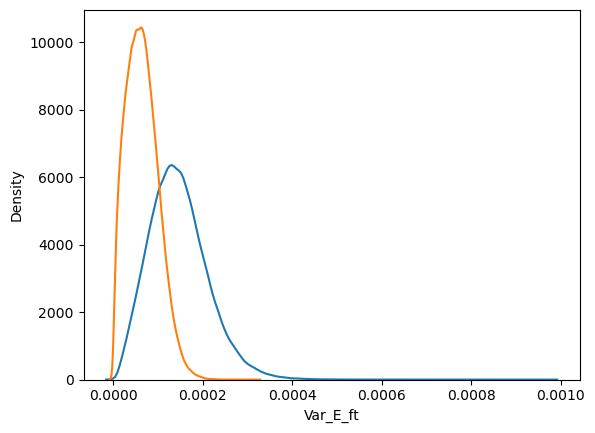

In [22]:
sns.kdeplot(result['Var_E_ft'])
sns.kdeplot(result['Var_I_ft'])

<Axes: xlabel='Var_E_sb', ylabel='Density'>

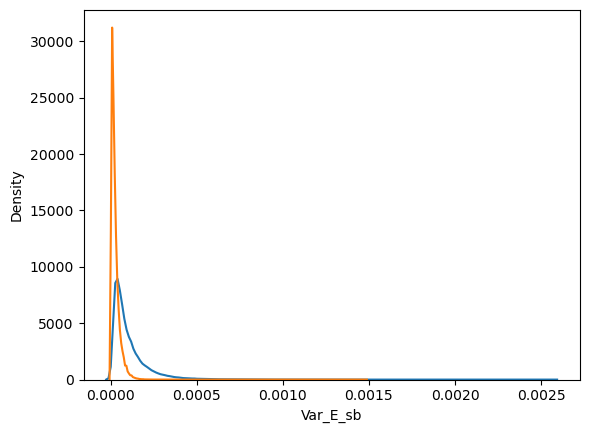

In [23]:
sns.kdeplot(result['Var_E_sb'])
sns.kdeplot(result['Var_I_sb'])

# **CI per text**

In [26]:
# get CI for each doc
records = {}

for doc, sims in doc_sim_dict.items():
    metrics = {}
    for model_key, model_label in [("ft", "ft"), ("sb", "sb")]:
        for sim_type in ["e", "i"]:
            key_prefix = f"{sim_type}_{model_key}"  # e_ft, i_ft, etc.
            scores = sims[f"{sim_type}_sim_{model_key}"]
            metrics[f"{key_prefix}_mean"] = np.mean(scores)
            metrics[f"{key_prefix}_std"] = np.std(scores)
            metrics[f"{key_prefix}_ci_lower"] = np.percentile(scores, 2.5)
            metrics[f"{key_prefix}_ci_upper"] = np.percentile(scores, 97.5)
    records[doc] = metrics

# Convert to DataFrame
summary_df = pd.DataFrame.from_dict(records, orient='index').reset_index()
summary_df = summary_df.rename(columns={"index": "doc_id"})
summary_df

,doc_id,e_ft_mean,e_ft_std,e_ft_ci_lower,e_ft_ci_upper,i_ft_mean,i_ft_std,i_ft_ci_lower,i_ft_ci_upper,e_sb_mean,e_sb_std,e_sb_ci_lower,e_sb_ci_upper,i_sb_mean,i_sb_std,i_sb_ci_lower,i_sb_ci_upper
0,danzbkr,0.476260,0.015494,0.458178,0.507671,0.523911,0.008664,0.514372,0.536796,0.270036,0.006720,0.248048,0.278770,0.395210,0.002760,0.391737,0.399695
1,fbbkgjz,0.309518,0.012110,0.295419,0.339999,0.339446,0.006023,0.332802,0.348971,0.057212,0.005446,0.047582,0.068220,0.199115,0.004574,0.192179,0.203540
2,c703i21,0.599546,0.008466,0.585088,0.614825,0.428373,0.008724,0.417629,0.442417,0.474488,0.013231,0.449148,0.500423,0.195073,0.004428,0.188983,0.199679
3,cxqslcl,0.603210,0.004314,0.594382,0.612338,0.496377,0.007519,0.487922,0.509257,0.429707,0.009198,0.410764,0.442110,0.278264,0.007275,0.270033,0.290176
4,gbjgkft,0.245654,0.020188,0.217648,0.277918,0.195169,0.006574,0.184470,0.202226,0.071496,0.014516,0.047127,0.093628,0.146917,0.004494,0.143275,0.155327
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
316566,eizd85n,0.459914,0.008038,0.447970,0.478855,0.436135,0.006563,0.426062,0.444292,0.271203,0.010115,0.249589,0.280794,0.199034,0.005140,0.192942,0.205579
316567,jeccop7,0.598255,0.003938,0.592185,0.605574,0.303965,0.003743,0.299438,0.309127,0.488191,0.008745,0.467580,0.501889,0.157949,0.006750,0.148457,0.167625
316568,gjygnpz,0.410599,0.011676,0.389508,0.434477,0.414490,0.006865,0.406800,0.423220,0.173183,0.004325,0.165310,0.179987,0.153940,0.004921,0.146128,0.161387
316569,fmsrtn6,0.391026,0.015555,0.371510,0.421378,0.461393,0.012063,0.447981,0.478631,0.192179,0.007281,0.181140,0.204191,0.251547,0.004912,0.245072,0.255851


## **Check if true Similarity Scores is within CI**

In [25]:
subreddits = ["Ask_Politics", "Askpolitics", "PoliticalDebate", "PoliticalDiscussion", "NeutralPolitics", "politics"]

OG_texts_all = pd.DataFrame()

for subr in subreddits:

    if subr == "politics":
        
        df = pd.DataFrame()
        for i in range(8):
            df_temp = pd.read_csv(f"output_clipped/politics_{i}_emb.csv")[['msg_id_parent', 'msg_id_child', 'submission_id', 
                                                                           'subreddit', 'finetuned_parent_E', 'finetuned_parent_I', 'finetuned_child_E',
                                                                           'finetuned_child_I', 'finetuned_submission_E', 'finetuned_submission_I',
                                                                           'self_parent_E', 'self_parent_I', 'self_child_E', 'self_child_I',
                                                                           'self_submission_E', 'self_submission_I']]
            df = pd.concat([df, df_temp]).reset_index(drop = True)
            print("Done with politics")

    else:
        df = pd.read_csv(f"output_clipped/{subr}_emb.csv")[['msg_id_parent', 'msg_id_child', 'submission_id', 'subreddit', 
                                                            'finetuned_parent_E', 'finetuned_parent_I', 'finetuned_child_E',
                                                            'finetuned_child_I', 'finetuned_submission_E', 'finetuned_submission_I',
                                                            'self_parent_E', 'self_parent_I', 'self_child_E', 'self_child_I',
                                                            'self_submission_E', 'self_submission_I']]
    
    
    comments_df = df[['subreddit', 'msg_id_parent', 'finetuned_parent_E', 'finetuned_parent_I', 
                      'self_parent_E','self_parent_I']].dropna().drop_duplicates().copy()
    comments_df.columns = ['subreddit', 'id', 'finetuned_E', 'finetuned_I', 'self_E', 'self_I']
    comments_df['type'] = 'parent'
    
    
    
    replies_df = df[['subreddit', 'msg_id_child', 'finetuned_child_E', 'finetuned_child_I', 
                      'self_child_E','self_child_I']].dropna().drop_duplicates().copy()
    replies_df.columns = ['subreddit', 'id', 'finetuned_E', 'finetuned_I', 'self_E', 'self_I']
    replies_df['type'] = 'child'
    
    subs_df = df[['subreddit', 'submission_id', 'finetuned_submission_E', 'finetuned_submission_I', 
                      'self_submission_E','self_submission_I']].dropna().drop_duplicates().copy()
    subs_df.columns = ['subreddit', 'id', 'finetuned_E', 'finetuned_I', 'self_E', 'self_I']
    subs_df['type'] = 'submission'
    
    # Concatenate into one unified dataframe
    OG_texts_df = pd.concat([comments_df, replies_df, subs_df], ignore_index=True)
    OG_texts_all = pd.concat([OG_texts_all, OG_texts_df]).reset_index(drop = True)
    
    
OG_texts_all

Done with politics
Done with politics
Done with politics
Done with politics
Done with politics
Done with politics
Done with politics
Done with politics


,subreddit,id,finetuned_E,finetuned_I,self_E,self_I,type
0,Ask_Politics,c7ecp8d,0.569184,0.532900,0.527911,0.386824,parent
1,Ask_Politics,c7efx8q,0.503059,0.494470,0.430944,0.294815,parent
2,Ask_Politics,c7edr13,0.420311,0.508084,0.132278,0.293948,parent
3,Ask_Politics,c7ee45j,0.426746,0.346008,0.309778,0.208190,parent
4,Ask_Politics,c7ejopx,0.115915,0.192232,0.072135,0.147608,parent
...,...,...,...,...,...,...,...
6326394,politics,18mfx16,0.464296,0.395060,0.259423,0.206317,submission
6326395,politics,18mfyba,0.464296,0.395060,0.259423,0.206317,submission
6326396,politics,18p9iet,0.511965,0.451997,0.272801,0.173581,submission
6326397,politics,18qmiau,0.558398,0.557344,0.361803,0.332093,submission


In [33]:
OG_texts_all['id'].nunique() == len(OG_texts_all)


duplicate_ids = OG_texts_all['id'][OG_texts_all['id'].duplicated(keep=False)]
print(OG_texts_all[OG_texts_all['id'].isin(duplicate_ids)])


            subreddit       id  finetuned_E  finetuned_I    self_E    self_I  \
519      Ask_Politics  c82rx74     0.466327     0.512424  0.350062  0.379679   
520      Ask_Politics  c82rx74     0.466327     0.512424  0.350062  0.379679   
1249     Ask_Politics  c92p1ei     0.521714     0.606304  0.384130  0.427147   
1250     Ask_Politics  c92p1ei     0.521714     0.606304  0.384130  0.427147   
1253     Ask_Politics  c92pljj     0.484875     0.594341  0.378567  0.420997   
...               ...      ...          ...          ...       ...       ...   
6326344      politics  17aroz3     0.343241     0.295833  0.293672  0.312286   
6326358      politics  17matua     0.440024     0.457089  0.332298  0.277942   
6326359      politics  17matua     0.440024     0.457089  0.332298  0.277942   
6326376      politics  187nfn2     0.398887     0.466576  0.301016  0.277465   
6326377      politics  187nfn2     0.398887     0.466576  0.301016  0.277465   

               type  
519          pare

In [34]:
OG_texts_all = OG_texts_all.drop_duplicates(subset='id')


In [36]:
summary_df = summary_df.merge(OG_texts_all[['id', 'finetuned_E', 'finetuned_I', 'self_E', 'self_I']], left_on = "doc_id", right_on = "id", how = 'left')


In [37]:

def check_within_ci(row, og_val_col, ci_low_col, ci_up_col):
    og_val = row[og_val_col]
    return row[ci_low_col] <= og_val <= row[ci_up_col]

# Add boolean flags for each model-concept
summary_df["in_ci_i_ft"] = summary_df.apply(lambda row: check_within_ci(row, "finetuned_I", "i_ft_ci_lower", "i_ft_ci_upper"), axis=1)
summary_df["in_ci_e_ft"] = summary_df.apply(lambda row: check_within_ci(row, "finetuned_E", "e_ft_ci_lower", "e_ft_ci_upper"), axis=1)
summary_df["in_ci_i_sb"] = summary_df.apply(lambda row: check_within_ci(row, "self_I", "i_sb_ci_lower", "i_sb_ci_upper"), axis=1)
summary_df["in_ci_e_sb"] = summary_df.apply(lambda row: check_within_ci(row, "self_E", "e_sb_ci_lower", "e_sb_ci_upper"), axis=1)

In [38]:
summary_df.to_csv("output_bootstrapping/doc_in_CI.csv", index = False)

In [ ]:
summary_df = pd.read_csv("output_bootstrapping/doc_in_CI.csv")

In [41]:
# Calculate shares
ci_results = {
    "ft_E": summary_df["in_ci_e_ft"].mean(),
    "ft_I": summary_df["in_ci_i_ft"].mean(),
    "sb_E": summary_df["in_ci_e_sb"].mean(),
    "sb_I": summary_df["in_ci_i_sb"].mean()
}

# Optional: turn into a DataFrame for better display
ci_results_df = pd.DataFrame.from_dict(ci_results, orient='index', columns=["share_in_CI"]).reset_index()
ci_results_df.rename(columns={"index": "model_concept"}, inplace=True)
ci_results_df

,model_concept,share_in_CI
0,ft_E,0.932022
1,ft_I,0.841401
2,sb_E,0.877860
3,sb_I,0.486052


In [42]:
# Assuming you already have ci_results_df from previous step
ci_results_df[["model", "concept"]] = ci_results_df["model_concept"].str.split("_", expand=True)
ci_results_df

,model_concept,share_in_CI,model,concept
0,ft_E,0.932022,ft,E
1,ft_I,0.841401,ft,I
2,sb_E,0.877860,sb,E
3,sb_I,0.486052,sb,I


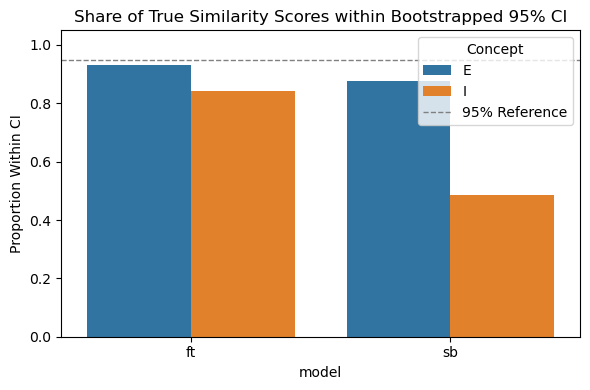

In [44]:
custom_palette = {
    "E": "#1F77B4",   # blue
    "I": "#FF7F0E"   # orange
}

plt.figure(figsize=(6, 4))
sns.barplot(
    data=ci_results_df,
    x="model",
    y="share_in_CI",
    hue="concept",
    palette=custom_palette
)

plt.ylim(0, 1.05)
plt.axhline(0.95, color="gray", linestyle="--", linewidth=1, label="95% Reference")
plt.ylabel("Proportion Within CI")
plt.title("Share of True Similarity Scores within Bootstrapped 95% CI")
plt.legend(title="Concept")
plt.tight_layout()
plt.savefig("output_bootstrapping/doc_shares_plot.pdf")
plt.show()